In [1]:
import sys
import glob
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

#### Load the network and the best weights

In [2]:
networks_path = '../trained_networks/'
# depth level = 1, loss function: MAPE
# optim_run = '20201206-221201'
# depth level = 1, loss function: MAE
optim_run = '20201206-221238'
# depth level = 2, loss function: MAPE
# optim_run = '20201207-154625'
# depth level = 2, loss function: MAE
# optim_run = '20201207-154851'
checkpoint_path = networks_path + optim_run + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(networks_path + optim_run + '/parameters.pkl', 'rb'))
val_loss = [float(file[:-3].split('-')[-1]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[np.argmin(val_loss)]
best_model = tf.keras.models.load_model(best_checkpoint, compile=True)
print('Loaded network from {}.'.format(best_checkpoint))

Loaded network from ../trained_networks/20201206-221238/checkpoints/weights.1610-0.40.h5.


#### We need mean and standard deviation of the training set to normalize the data

In [3]:
try:
    x_train_mean = network_parameters['x_train_mean']
    x_train_std  = network_parameters['x_train_std']
except:
    # Load the data used to train the network to compute the mean
    # and standard deviation of the training set if this is not
    # contained in the parameters file
    data_folder = '../pan/npz_files'
    inertia = {'training': np.arange(2,11)}
    _, x, y = load_data(data_folder, inertia)
    x['train'] = x.pop('training')
    y['train'] = y.pop('training')
    x_train_mean = np.mean(x['train'])
    x_train_std = np.std(x['train'])

In [4]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 596, 16)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 16)           0         
_________________________________________________________________
re_lu (ReLU)                 (None, 149, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 145, 32)           2592      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 32)            0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 36, 32)            0

#### A couple of functions used in the following

In [5]:
def load_data(data_files, var_name='omegacoi', window_dur = 60, window_step = 10):
    
    data = [np.load(data_file, allow_pickle=True) for data_file in data_files]
    time = [data[0]['time']]
    for i in range(1,len(data)):
        time.append(data[i]['time'] + data[i-1]['time'][-1])
    time = np.concatenate(time)
    N_samples = time.size
    omega = np.concatenate([entry[var_name] for entry in data])
    omega_normalized = (omega - x_train_mean) / x_train_std

    try:
        simulation_parameters = data[0]['parameters'].item()
    except:
        simulation_parameters = {'frand': 10}

    dt = 1 / simulation_parameters['frand']
    window_dur = 60 # [s]
    window_size = int(window_dur / dt)
    window_step = 10
    print('Window size: {:d} samples'.format(window_size))

    omega_sliding, indexes = slide_window(omega_normalized, window_size, window_step=window_step)
    print('Number of trials: {:d}'.format(omega_sliding.shape[0]))
    
    return time, omega, omega_sliding, indexes, simulation_parameters


def predict(omega_sliding, model, window_step, dt, rolling_length=50):
    x = tf.constant(omega_sliding, dtype=tf.float32)
    y = np.squeeze(model.predict(x))
    H = pd.DataFrame(data = {'inertia': y}).rolling(rolling_length).mean().to_numpy()
    time = np.arange(H.size) * window_step * dt
    return time, H, y

### First example
1. H steps **instantaneously** from 3.5 to 8.5
1. **omega of the center of inertia** used for the estimation
1. two simulations joined together (i.e., **no transient** during the step)

Window size: 600 samples
Number of trials: 7140


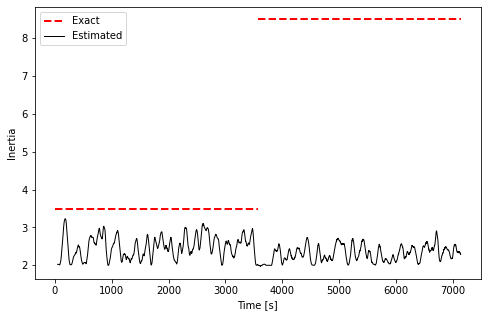

In [12]:
data_file = '../pan/ieee14_H={:.1f}.npz'
data_files = [data_file.format(h) for h in [3.5,8.5]]

var_name = 'G8:omega'
window_dur = 60
window_step = 10

t, _, omega_sliding, indexes, sim_pars = load_data(data_files, var_name, window_dur, window_step)
dt = np.diff(t[:2])[0]
time, H, _ = predict(omega_sliding, best_model, window_step, dt)

fig,ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(time[[0,int(time.size/2)]], sim_pars['H'] + np.zeros(2), 'r--', lw=2, label='Exact')
ax.plot(time[[int(time.size/2),-1]], sim_pars['H'] + 5 + np.zeros(2), 'r--', lw=2)
ax.plot(time, H, 'k', lw=1, label='Estimated')
ax.legend(loc='best')
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Inertia');

In [9]:
data = np.load(data_files[0])
data.files

['time',
 'omega01',
 'omega02',
 'G3:omega',
 'G6:omega',
 'G8:omega',
 'omegacoi',
 'parameters']

### Second example
1. H steps **instantaneously** from 3.5 to 8.5
1. **omega of generator 1** used for the estimation
1. two simulations joined together (i.e., **no transient** during the step)

Window size: 600 samples
Number of trials: 7140


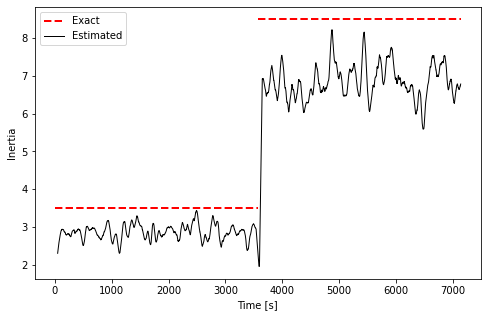

In [28]:
data_file = '../pan/ieee14_H={:.1f}.npz'
data_files = [data_file.format(h) for h in [3.5,8.5]]

var_name = 'omega01'
window_dur = 60
window_step = 10

t, _, omega_sliding, indexes, sim_pars = load_data(data_files, var_name, window_dur, window_step)
dt = np.diff(t[:2])[0]
time, H, _ = predict(omega_sliding, best_model, window_step, dt)

fig,ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(time[[0,int(time.size/2)]], sim_pars['H'] + np.zeros(2), 'r--', lw=2, label='Exact')
ax.plot(time[[int(time.size/2),-1]], sim_pars['H'] + 5 + np.zeros(2), 'r--', lw=2)
ax.plot(time, H, 'k', lw=1, label='Estimated')
ax.legend(loc='best')
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Inertia');

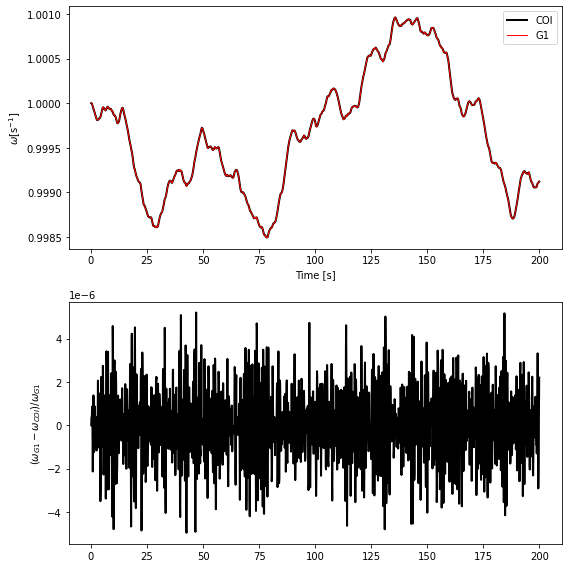

In [36]:
data = np.load(data_files[0])
time      = data['time']
omega_G1  = data['omega01']
omega_coi = data['omegacoi']
idx = time < 200
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(time[idx], omega_coi[idx], 'k', lw=2, label='COI')
ax1.plot(time[idx], omega_G1[idx], 'r', lw=1, label='G1')
ax1.set_ylabel(r'$\omega [\mathrm{s}^{-1}]$')
ax1.legend(loc='best')

ax2.plot(time[idx], (omega_G1[idx] - omega_coi[idx]) / omega_G1[idx], \
         'k', lw=2, label='COI')
ax1.set_xlabel('Time [s]')
ax2.set_ylabel(r'$(\omega_{G1} - \omega_{COI}) / \omega_{G1}$')
fig.tight_layout()

### Third example
1. H steps **gradually** from 3.5 to 6.5 in 100 seconds (from t = 3550s to t=3650s)
1. **omega of generator 1** used for the estimation

Window size: 600 samples
Number of trials: 7140


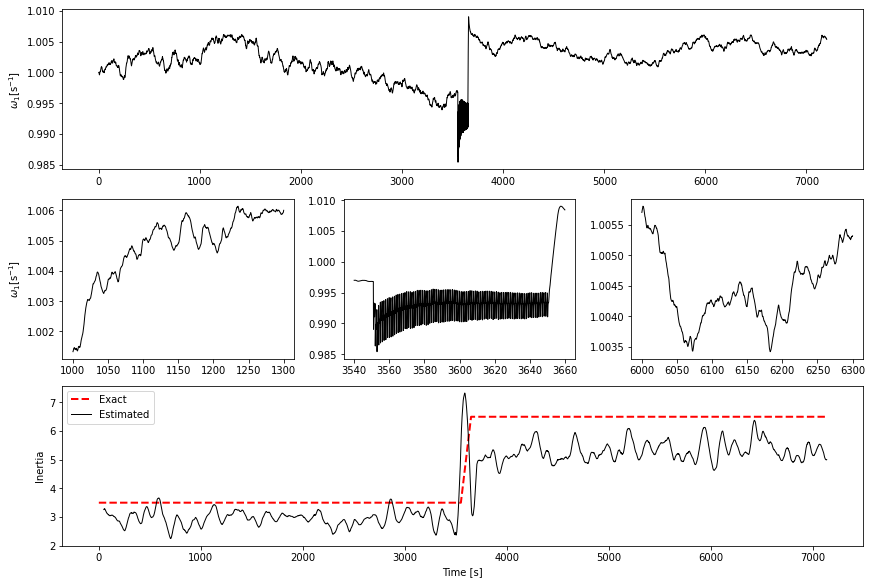

In [41]:
data_files = ['../pan/ieee14_H=3.5-6.5_ramp.npz']

var_name = 'omega01'
window_dur = 60
window_step = 10

t, omega, omega_sliding, indexes, sim_pars = load_data(data_files, var_name, window_dur, window_step)
dt = np.diff(t[:2])[0]
time, H, _ = predict(omega_sliding, best_model, window_step, dt)

### real value of inertia
H_min = 3.5
H_max = 6.5
H_ref = H_min + np.zeros(time.shape)
idx, = np.where((time > 3550) & (time <= 3650))
H_ref[idx] = np.linspace(H_min, H_max, idx.size)
H_ref[time > 3650] = H_max

fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0,:])
ax21 = fig.add_subplot(gs[1,0])
ax22 = fig.add_subplot(gs[1,1])
ax23 = fig.add_subplot(gs[1,2])
ax3 = fig.add_subplot(gs[2,:])

ax1.plot(t, omega, 'k', lw=1)
ax1.set_ylabel(r'$\omega_1 [\mathrm{s}^{-1}]$')

idx = (t > 1000) & (t < 1300)
ax21.plot(t[idx], omega[idx], 'k', lw=1)
idx = (t > 3540) & (t < 3660)
ax22.plot(t[idx], omega[idx], 'k', lw=1)
idx = (t > 6000) & (t < 6300)
ax23.plot(t[idx], omega[idx], 'k', lw=1)
ax21.set_ylabel(r'$\omega_1 [\mathrm{s}^{-1}]$')

ax3.plot(time, H_ref, 'r--', lw=2, label='Exact')
ax3.plot(time, H, 'k', lw=1, label='Estimated')
ax3.legend(loc='best')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel(r'Inertia');


#### TODO
1. D=2, DZA=1: damping, super-wide dead-band
1. D=2, DZA=36e-3/60: damping, realistic dead-band
1. D=0, DZA=0.36/60: no damping, wide dead-band